In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

data_file='/Users/john/data-sets/creditcard.csv'
data=pd.read_csv(data_file,header=0)

print(data.dtypes.head())
print('Number of records:',len(data))
data.head()

Time    float64
V1      float64
V2      float64
V3      float64
V4      float64
dtype: object
Number of records: 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

feature_names=data.columns.values[:-1]
train_test_set = data[data.Class==0][feature_names]
train_set, test_set = train_test_split(train_test_set, test_size=0.2, random_state=42)
scaler=MinMaxScaler().fit(train_set)
file=open('min-max-scaler.pkl','wb')
pickle.dump(scaler,file)
file.close()

ds_fraud=data[data.Class==1][feature_names]
ds_normal=test_set.sample(n=len(ds_fraud),random_state=42)
ds_fraud=scaler.transform(ds_fraud)
ds_normal=scaler.transform(ds_normal)

[  0.         -56.40750963 -72.71572756 -33.68098402  -5.6831712
 -42.14789837 -26.16050594 -31.76494649 -73.21671846  -6.29073039
 -14.74109638  -4.79747346 -15.14498822  -5.79188121 -18.3920915
  -4.39130707 -10.11555995 -17.09844421  -5.36665996  -7.21352743
 -28.00963533 -34.83038214 -10.9331437  -44.8077352   -2.8248489
 -10.29539707  -2.60455055 -22.56567932 -11.71089564   0.        ] [1.72788000e+05 2.45492999e+00 1.89024528e+01 9.38255843e+00
 1.68753440e+01 3.48016659e+01 2.39178371e+01 4.40544614e+01
 1.87092545e+01 1.55949946e+01 2.37451361e+01 1.00021902e+01
 7.84839208e+00 4.56900896e+00 1.05267661e+01 5.78451389e+00
 8.28988956e+00 9.25352625e+00 5.04106919e+00 5.59197143e+00
 3.94209042e+01 2.26148894e+01 1.05030901e+01 2.25284117e+01
 4.02286589e+00 7.51958868e+00 3.46324565e+00 1.21524011e+01
 3.38478078e+01 1.96565300e+04]


In [10]:
class autoencoder(nn.Module):
    def __init__(self,num_input):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 15),
            nn.ReLU(True),
            nn.Linear(15, 7))
        self.decoder = nn.Sequential(
            nn.Linear(7, 15),
            nn.ReLU(True),
            nn.Linear(15, num_input),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Split point: tensor(-1.1369)
0.8760162601626016
0.8943089430894309


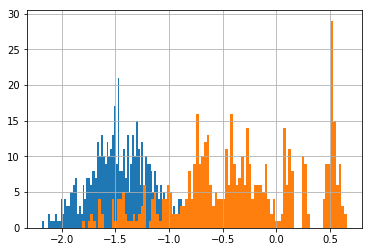

In [16]:
model = autoencoder(ds_normal.shape[1])
model.load_state_dict(torch.load('/Users/john/projects/cloudera-ml/anomaly-detection/creditcard-fraud-minmaxscale.model'))
model.eval()

with torch.no_grad():
    inputs2=torch.tensor(ds_fraud, dtype=torch.float32)
    outputs2=model(inputs2)
    loss2=torch.sum((inputs2-outputs2)**2,dim=1).sqrt().log()

    inputs1=torch.tensor(ds_normal, dtype=torch.float32)
    outputs1=model(inputs1)
    loss1=torch.sum((inputs1-outputs1)**2,dim=1).sqrt().log()

    pd.Series(loss1.numpy()).hist(bins=100)
    pd.Series(loss2.numpy()).hist(bins=100)
    split_point=(loss1.max()+loss2.min())/2
    print('Split point:',split_point)
    print((loss1<split_point).sum().item()/float(len(loss1)))
    print((loss2>split_point).sum().item()/float(len(loss2)))

Split point: tensor(-1.5674)
0.9186991869918699
0.9085365853658537


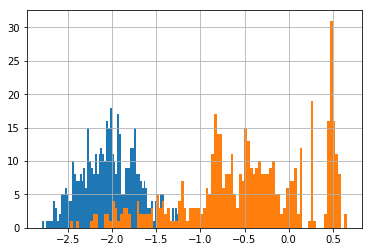

In [18]:
model.load_state_dict(torch.load('/Users/john/projects/cloudera-ml/anomaly-detection/creditcard-fraud-minmaxscale-2.model'))
model.eval()

with torch.no_grad():
    inputs2=torch.tensor(ds_fraud, dtype=torch.float32)
    outputs2=model(inputs2)
    loss2=torch.sum((inputs2-outputs2)**2,dim=1).sqrt().log()

    inputs1=torch.tensor(ds_normal, dtype=torch.float32)
    outputs1=model(inputs1)
    loss1=torch.sum((inputs1-outputs1)**2,dim=1).sqrt().log()

    pd.Series(loss1.numpy()).hist(bins=100)
    pd.Series(loss2.numpy()).hist(bins=100)
    split_point=(loss1.max()+loss2.min())/2
    print('Split point:',split_point)
    split_point=-1.5
    print((loss1<split_point).sum().item()/float(len(loss1)))
    print((loss2>split_point).sum().item()/float(len(loss2)))